In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
import pickle

DATA_NEW="../data/delhi_aqi_new.csv" # change with your path
DATA_OLD="../data/delhi_aqi.csv" # change with your path

df = pd.read_csv(DATA_NEW)
df_work = df.copy()
df_work['date']=pd.to_datetime(arg=df_work['date'],format="%Y-%m-%d %H:%M:%S")
df_work.set_index('date',inplace=True)
df_work = df_work.resample('D').agg({
    'pm10': 'mean',
    'nh3': 'mean',
    'pm2_5': 'mean',
    'co': 'mean',
    'no': 'mean',
    'no2': 'mean',
    'o3': 'mean',
    'so2': 'mean'
})
df_work.interpolate(method='linear', inplace=True)

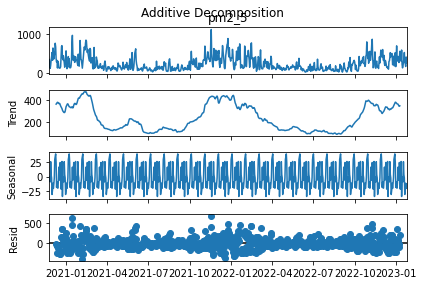

In [9]:
# 1.Time series decomposition
adec=seasonal_decompose(df_work['pm2_5'],model='additive',period=30)
adec.plot()
plt.suptitle('Additive Decomposition')
plt.show()

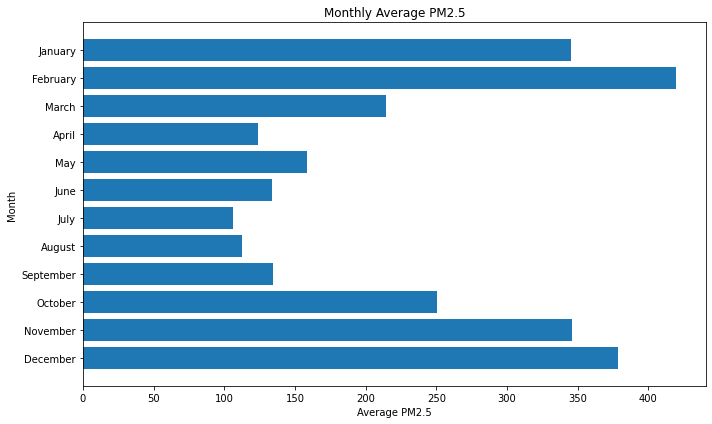

In [10]:
# 2. Time Series Visualization
df_copy=df[['date', 'pm2_5']].copy()

df_copy['date'] = pd.to_datetime(df_copy['date'])

df_copy.set_index('date', inplace=True)

monthly_avg = df_copy.resample('ME').mean()
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
            7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
monthly_avg['Month'] = monthly_avg.index.month
monthly_avg['Month'] = monthly_avg['Month'].map(month_names)
monthly_avg_comb = monthly_avg.groupby('Month')['pm2_5'].mean()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
            'July', 'August', 'September', 'October', 'November', 'December']

monthly_avg_comb.index = pd.CategoricalIndex(monthly_avg_comb.index, categories=month_order, ordered=True)
monthly_avg_sorted = monthly_avg_comb.sort_index(ascending=False)

plt.figure(figsize=(10, 6))

# Creating a horizontal bar chart
plt.barh(monthly_avg_sorted.index, monthly_avg_sorted.values)

# Customizing the plot
plt.title('Monthly Average PM2.5')
plt.xlabel('Average PM2.5')
plt.ylabel('Month')
plt.tight_layout()

plt.show()

In [11]:
# 3. Description of Time series
'''
Stationary: Yes, the data is stationary as the ADFuller test indicates. 
Trends: There appear to be trends in the data. Mainly when transitioning to and from the winter months.
Seasonality: Yes, there appears to be seasonality in this data. The values are particularly high in the winter months and lower in the summer months.
'''

'\nStationary: Yes, the data is stationary as the ADFuller test indicates. \nTrends: There appear to be trends in the data. Mainly when transitioning to and from the winter months.\nSeasonality: Yes, there appears to be seasonality in this data. The values are particularly high in the winter months and lower in the summer months.\n'

In [12]:
# 4. TS models
'''
SARIMAX
The data was first resampled from hourly to daily and then modeled. I found some seasonality in the data and that is why i chose to use the SARIMAX model over the ARIMA model.
The SARIMAX model provided slightly better results when comparing the RMSE and MAPE. The SARIMAX model in this case may not be the best because it is not able to take recognize
some of the relationships between the different times series. For instance Nainesh had pointed out earlier that there is a high correlation between PM2_5 and CO pollution levels.
Using a model that can model that relationship might further improve the predictions

RMSE: 139.91
MAPE: 46.81%
'''
split_point = round((df_work.shape[0]*0.8)+3)
train, test = df_work['pm2_5'].iloc[:split_point], df_work['pm2_5'].iloc[split_point:]
history = [x for x in train]
predictions = list()

#save model
final_model = SARIMAX(history, order=(3, 0, 0))
final_model_fit = final_model.fit(disp=0)
with open('final_sarimax_model.pkl', 'wb') as file:
    pickle.dump(final_model_fit, file)

# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(3, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t] 
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.2f' % rmse)
mape = mean_absolute_percentage_error(test.values, predictions) * 100
print(f"MAPE: {mape:.2f}%")

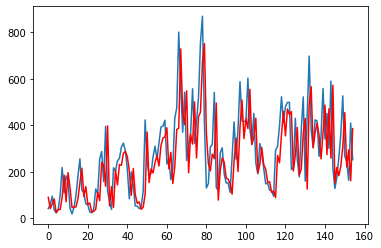

In [ ]:
# 5. Predictions
'''
SARIMAX Prediction
'''
plt.plot(test.values)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
# 6. Team Contributions

"""
Sam's Contribution:
    - Data decomposition
        - Since the seasonal variation was fairly consistent over time it made sense to use an additive decomposition.
    - Added visual of monthly average of PM 2.5
        - This was interesting as you could immediately observe some seasonality from this graph.
    - Modeled the data using SARIMAX
        - Used SARIMAX to model the data as Sarthak was modeling it using a NBeats Model, this offers us a look at too different types of models.
    Total Time: 5hrs
"""

"\nSam's Contribution:\n    - Data decomposition\n        - Since the seasonal variation was fairly consistent over time it made sense to use an additive decomposition.\n    - Added visual of monthly average of PM 2.5\n        - This was interesting as you could immediately observe some seasonality from this graph.\n    - Modeled the data using SARIMAX\n        - Used SARIMAX to model the data as Sarthak was modeling it using a NBeats Model, this offers us a look at too different types of models.\n    Total Time: 5hrs\n"